## Compare repeated scans between different phases of the survey
### A. Ordog, October 31, 2022

## Import packages

In [16]:
import imp
import os
import subprocess
import h5py
import numpy as np
from astropy.time import Time
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import HourLocator as HourLocator
from matplotlib.dates import MinuteLocator as MinuteLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy import units as u
from astropy.time import TimeDelta


## Select survey phase:

In [18]:
#### User input  - phases to compare: #####
phases = [1,2]
###########################################

dir_files = '/srv/data/dva/survey_azimuth_scans_noise_corr/'
#dir_files = '/srv/data/dva/survey_azimuth_scans/'

## Define functions

In [12]:
def make_scan_phase_dictionary(phases,dir_files):

    if len(phases)<2:
        print('Error: must compare at least two phases')

    scandict = {} 
    scanids = []
    scan_phase = []

    #all_scans = os.popen('ls -1 -R '+dir_files+'dva_survey_phase*').read().split()
    all_scans = os.popen('ls -1 -R '+dir_files+'dva_survey_phase* |xargs -n1 basename').read().split()
    #print(all_scans)

    for i in range(1,len(all_scans)):
        #print(all_scans[i])
        scanids.append(all_scans[i][22:26])
        scan_phase.append(all_scans[i][16])
    
    scan_phase = np.asarray(scan_phase).astype(np.int)
    scanids = np.asarray(scanids).astype(np.int)

    for phase in phases:
        w = np.where(scan_phase == phase)[0]
        scandict.update({"phase"+str(phase): scanids[w]}) 

    return scandict


def get_overlapping_scan_ids(scandict,list_scans=True,*args,**kwargs):
    
    keys_list = list(scandict.keys())
    all_lists = [set(scandict[i]) for i in keys_list]
    
    if len(phases) == 2:
        phases_str = str(keys_list[0])+' & '+str(keys_list[1])
        overlap_scans = list(set.intersection(set(all_lists[0]),
                                              set(all_lists[1])))
    if len(phases) == 3:
        phases_str = str(keys_list[0])+' & '+str(keys_list[1]+' & '+str(keys_list[2]))
        overlap_scans = list(set.intersection(set(all_lists[0]),
                                              set(all_lists[1]),
                                              set(all_lists[2])))
        
    if list_scans:
        print(str(len(overlap_scans))+' overlapping scans \nbetween '+phases_str+':')
        print('')
        for scan in overlap_scans:
            print(scan)
       
    return overlap_scans

def read_in_scan(scan_id,dir_files,phase):
    
    scan = f"{scan_id:04}"
    file = h5py.File(dir_files+'dva_survey_phase'+str(phase)+'_raw_'+scan+'_gain_corr.h5','r')
    #file = h5py.File(dir_files+'dva_survey_phase'+str(phase)+'_raw_'+scan+'.h5','r')
    
    dataset = file['data']['beam_0']['band_SB0']['scan_0']
    
    freq = file['data']['beam_0']['band_SB0']['frequency']
    
    dec = dataset['metadata']['declination']
    ra = dataset['metadata']['right_ascension']
    el = dataset['metadata']['elevation']
    az = dataset['metadata']['azimuth']
    t = dataset['metadata']['utc']
    noise = dataset['metadata']['noise_state']
    trim_flag = dataset['metadata']['trim_scan_flag']
    
    RR = dataset['data'][:,0,:]
    LL = dataset['data'][:,1,:]
    reRL = dataset['data'][:,2,:]
    imRL = dataset['data'][:,3,:]
    
    print(t[0])
    
    return RR,LL,reRL,imRL,freq,dec,ra,el,az,t,noise,trim_flag


## Create dictionary of scans and list overlapping ones:

In [19]:
scandict = make_scan_phase_dictionary(phases,dir_files)

overlap_scans = get_overlapping_scan_ids(scandict,list_scans=True)


22 overlapping scans 
between phase1 & phase2:

132
133
134
1286
2436
2581
278
920
2588
1573
1074
576
2368
2369
1358
1870
855
357
629
630
1141
1142


## Pick a scan to examine:

In [20]:
### User input - select scan from list above
scan_pick = 576
############################################

# Note: the following assumes we are only comparing a single scan from TWO phases of the survey.
# Will generalize this later to allow for three phase-comparison and better naming scheme for
# the data read in.
RR1,LL1,reRL1,imRL1,freq1,dec1,ra1,el1,az1,t1,noise1,trim_flag1 = read_in_scan(scan_pick,dir_files,1)
RR2,LL2,reRL2,imRL2,freq2,dec2,ra2,el2,az2,t2,noise2,trim_flag2 = read_in_scan(scan_pick,dir_files,2)


b'2022-07-18T12:07:21.800006Z'
b'2022-08-28T09:26:09.200003Z'


## Simple comparison plot at one frequency

802.1041666666667
802.1041666666667


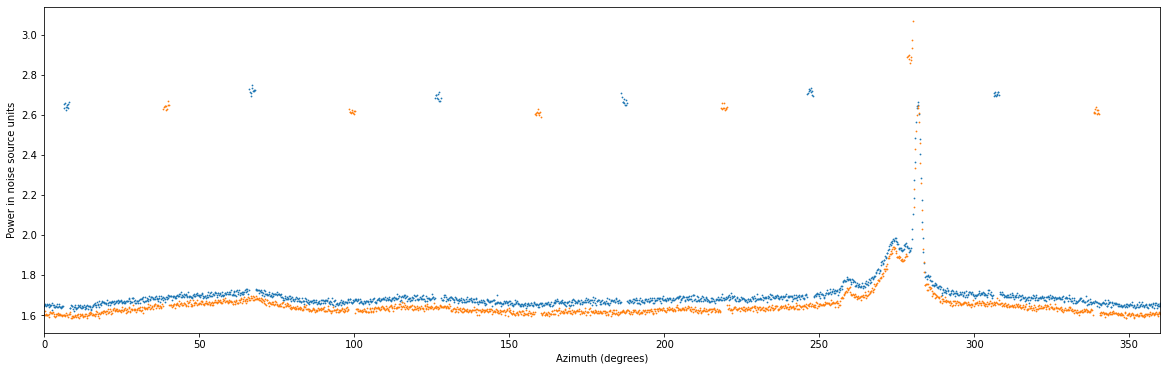

In [22]:
fig1, axs = plt.subplots(1,1,figsize=(20,6))

ii = 5500
t_plt1 = Time(t1, format='isot',scale='utc').mjd
t_plt2 = Time(t2, format='isot',scale='utc').mjd
axs.scatter(az1,RR1[:,ii],s=0.6)
axs.scatter(az2,RR2[:,ii],s=0.6)
#axs.set_ylim(1.5,2.5)
axs.set_xlim(0,360)
axs.set_xlabel('Azimuth (degrees)')
axs.set_ylabel('Power in noise source units')

print(freq1[ii]/1e6)
print(freq2[ii]/1e6)